Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1202s 384ms/step - accuracy: 0.1045 - loss: 4.2592 - val_accuracy: 0.2128 - val_loss: 3.4935
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1340s 429ms/step - accuracy: 0.2389 - loss: 3.3235 - val_accuracy: 0.2342 - val_loss: 3.3470
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1293s 414ms/step - accuracy: 0.2739 - loss: 3.1192 - val_accuracy: 0.2517 - val_loss: 3.2808
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1367s 437ms/step - accuracy: 0.2976 - loss: 2.9950 - val_accuracy: 0.2614 - val_loss: 3.2383
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1491s 477ms/step - accuracy: 0.3184 - loss: 2.8719 - val_accuracy: 0.2605 - val_loss: 3.2855
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1350s 432ms/step - accuracy: 0.3303 - loss: 2.8191 - val_accuracy: 0.2646 - val_loss: 3.2689
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1383s 443ms/step - accuracy: 0.3455 - loss: 2.7310 - val_accuracy: 0.2660 - val_loss: 3.2949
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1461s 467ms/s

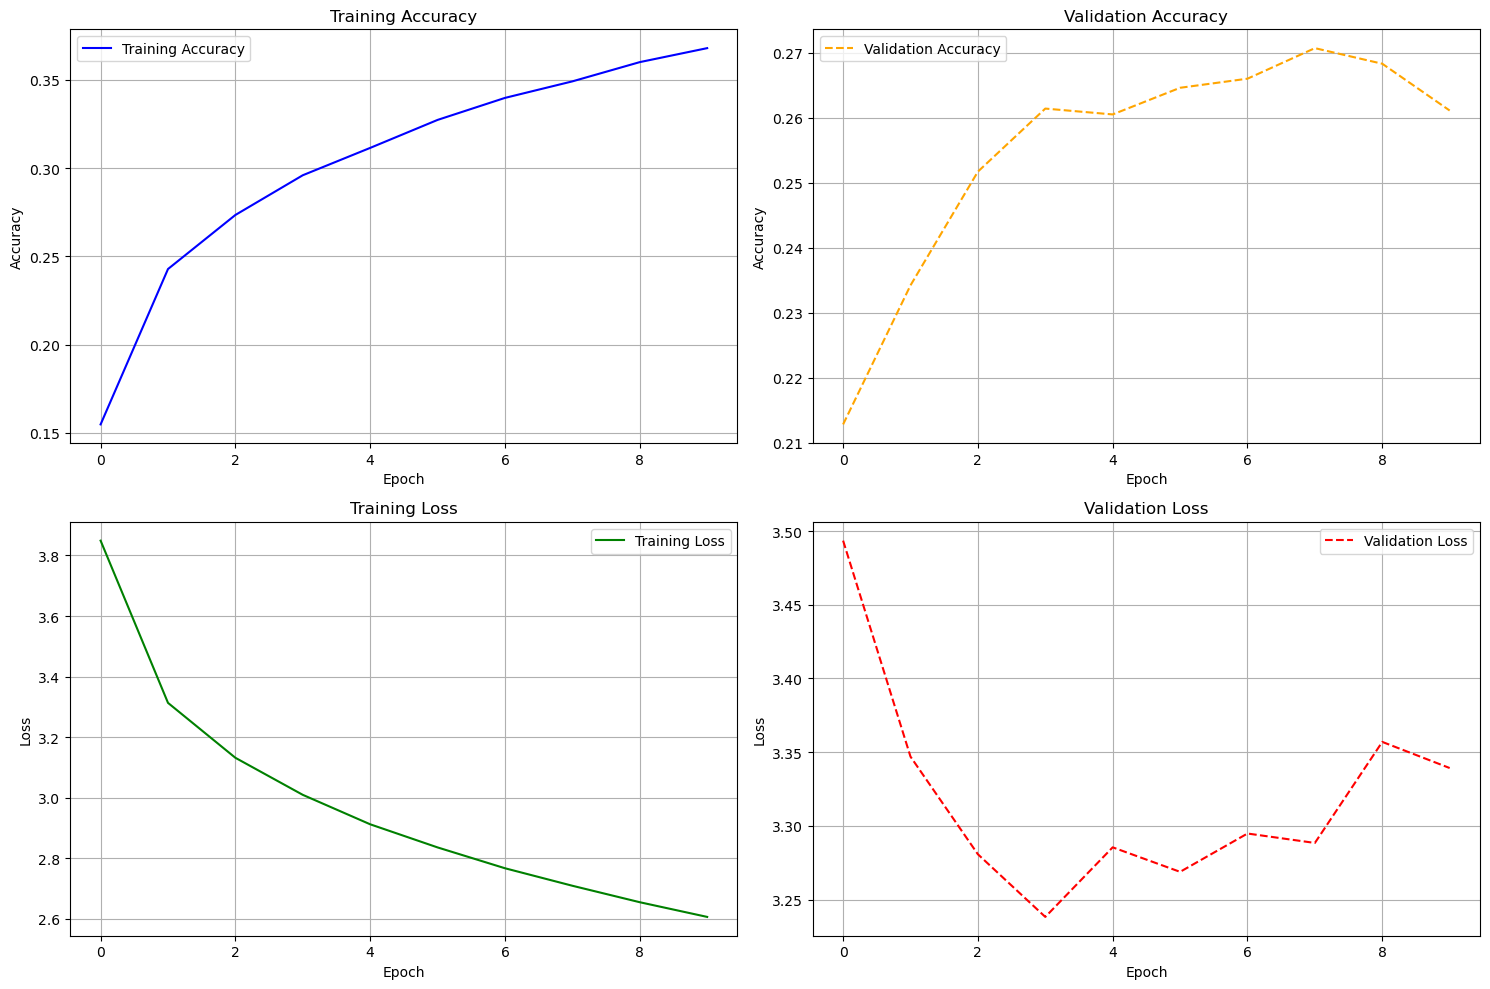


Results (Tiny ImageNet):
                        Model  Test Accuracy
0  Custom_Model_Tiny_ImageNet         0.2611


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load Tiny ImageNet dataset
def load_tiny_imagenet_dataset(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    meta_file = os.path.join(data_dir, 'wnids.txt')

    # Load class labels
    with open(meta_file, 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    # Load training images and labels
    x_train = []
    y_train = []
    for i, cls in enumerate(classes):
        cls_train_dir = os.path.join(train_dir, cls, 'images')
        img_files = os.listdir(cls_train_dir)
        for img_file in img_files:
            img_path = os.path.join(cls_train_dir, img_file)
            img = load_img(img_path, target_size=(64, 64))  # Resize images to (64, 64)
            img_array = img_to_array(img)
            x_train.append(img_array)
            y_train.append(i)

    # Load validation images and labels
    x_val = []
    y_val = []
    val_meta_file = os.path.join(val_dir, 'val_annotations.txt')
    with open(val_meta_file, 'r') as f:
        for line in f.readlines():
            img_file, cls = line.split('\t')[:2]
            img_path = os.path.join(val_dir, 'images', img_file)
            img = load_img(img_path, target_size=(64, 64))  # Resize images to (64, 64)
            img_array = img_to_array(img)
            x_val.append(img_array)
            y_val.append(classes.index(cls))

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)

    return x_train, y_train, x_val, y_val, classes

# Load Tiny ImageNet dataset
data_dir = '/Users/pc/Documents/UMKC/Spring 2024/Deep Learning/Project/Final Project/Final/IMagenet-master/tiny-imagenet-200/'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' not found. Please ensure the dataset directory is correct.")
x_train, y_train, x_val, y_val, classes = load_tiny_imagenet_dataset(data_dir)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# Define function for creating and training model
def train_model(base_model, model_name, x_train, y_train, x_val, y_val):
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(len(classes), activation='softmax')  # Adjust output size for Tiny ImageNet classes
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)

    test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose=0)
    print(f"Test accuracy for {model_name}: {test_accuracy}")

    # Save the model with the specified path
    model_path = f"{model_name}.keras" 
    save_model(model, model_path)  # Save the model to a file
    
    return {
        'Model': model_name,
        'Test Accuracy': test_accuracy,
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy'],
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    }, history

# Load pre-trained VGG19 model without top classification layer
vgg_base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Train the custom model on Tiny ImageNet
custom_results_tiny_imagenet, history_tiny_imagenet = train_model(vgg_base_model, "Custom_Model_Tiny_ImageNet", x_train, y_train, x_val, y_val)

print("Custom model for Tiny ImageNet saved successfully.")

# Plot single graph for all accuracies
plt.figure(figsize=(15, 10))

# Plot training accuracy
plt.subplot(2, 2, 1)
plt.plot(history_tiny_imagenet.history['accuracy'], label='Training Accuracy', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history_tiny_imagenet.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(2, 2, 3)
plt.plot(history_tiny_imagenet.history['loss'], label='Training Loss', linestyle='-', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(history_tiny_imagenet.history['val_loss'], label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Tabulate the results neatly
results_df_tiny_imagenet = pd.DataFrame({
    'Model': [custom_results_tiny_imagenet['Model']],
    'Test Accuracy': [custom_results_tiny_imagenet['Test Accuracy']]
})

print("\nResults (Tiny ImageNet):")
print(results_df_tiny_imagenet)


In [11]:
# Save results to CSV file
results_df_tiny_imagenet.to_csv("Tiny_ImageNet_results.csv", index=False)

## TinyImageNet for ResNet50

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 328s 104ms/step - accuracy: 0.0165 - loss: 5.1459 - val_accuracy: 0.0396 - val_loss: 4.8343
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 336s 108ms/step - accuracy: 0.0425 - loss: 4.7754 - val_accuracy: 0.0552 - val_loss: 4.6660
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 427s 137ms/step - accuracy: 0.0570 - loss: 4.6421 - val_accuracy: 0.0628 - val_loss: 4.6152
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 406s 130ms/step - accuracy: 0.0646 - loss: 4.5746 - val_accuracy: 0.0640 - val_loss: 4.6000
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 422s 135ms/step - accuracy: 0.0695 - loss: 4.5207 - val_accuracy: 0.0706 - val_loss: 4.5491
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 432s 138ms/step - accuracy: 0.0748 - loss: 4.4873 - val_accuracy: 0.0718 - val_loss: 4.5348
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 466s 149ms/step - accuracy: 0.0815 - loss: 4.4540 - val_accuracy: 0.0718 - val_loss: 4.5694
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 473s 151ms/step - ac

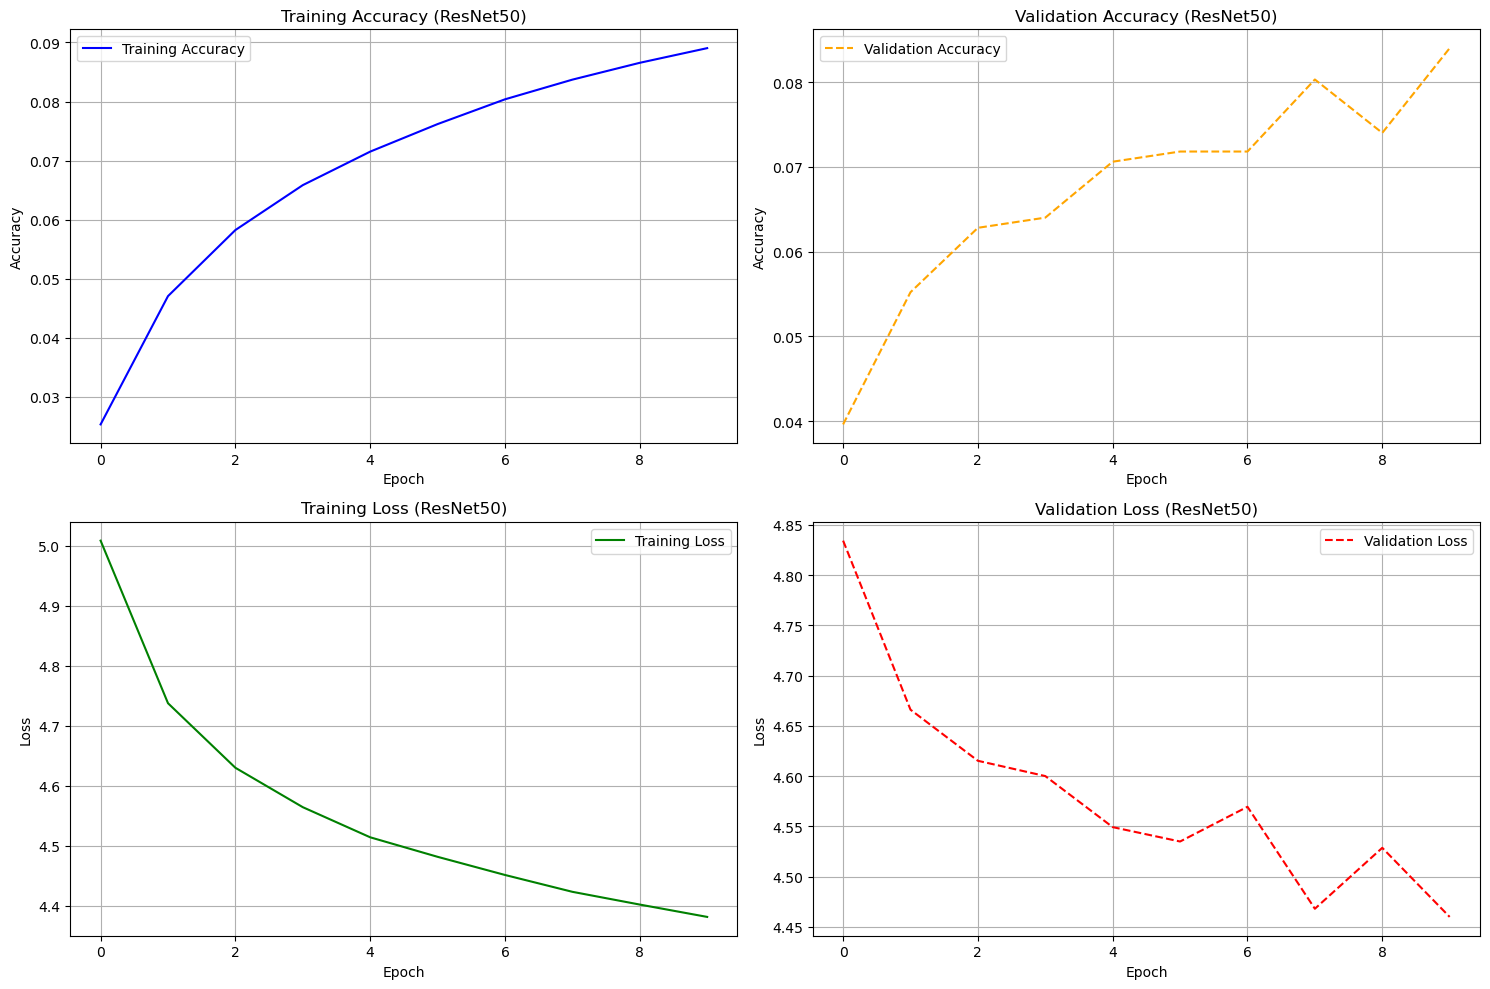


Results (Tiny ImageNet - ResNet50):
                               Model  Test Accuracy
0  Custom_Model_Tiny_ImageNet_ResNet          0.084
Results (Tiny ImageNet - ResNet50) saved to results_tiny_imagenet_resnet_20240511193011.csv


In [12]:
from tensorflow.keras.applications import ResNet50
import time

# Load pre-trained ResNet50 model without top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Train the custom model on Tiny ImageNet using ResNet50 base model
custom_results_tiny_imagenet_resnet, history_tiny_imagenet_resnet = train_model(resnet_base_model, "Custom_Model_Tiny_ImageNet_ResNet", x_train, y_train, x_val, y_val)

print("Custom ResNet50 model for Tiny ImageNet saved successfully.")

# Plot single graph for all accuracies using ResNet50
plt.figure(figsize=(15, 10))

# Plot training accuracy
plt.subplot(2, 2, 1)
plt.plot(history_tiny_imagenet_resnet.history['accuracy'], label='Training Accuracy', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy (ResNet50)')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history_tiny_imagenet_resnet.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy (ResNet50)')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(2, 2, 3)
plt.plot(history_tiny_imagenet_resnet.history['loss'], label='Training Loss', linestyle='-', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (ResNet50)')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(history_tiny_imagenet_resnet.history['val_loss'], label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss (ResNet50)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Tabulate the results neatly for ResNet50
results_df_tiny_imagenet_resnet = pd.DataFrame({
    'Model': [custom_results_tiny_imagenet_resnet['Model']],
    'Test Accuracy': [custom_results_tiny_imagenet_resnet['Test Accuracy']]
})

print("\nResults (Tiny ImageNet - ResNet50):")
print(results_df_tiny_imagenet_resnet)

# Get current timestamp
timestamp = time.strftime("%Y%m%d%H%M%S")

# Export results to CSV with timestamp
csv_filename = f"results_tiny_imagenet_resnet_{timestamp}.csv"
results_df_tiny_imagenet_resnet.to_csv(csv_filename, index=False)

print(f"Results (Tiny ImageNet - ResNet50) saved to {csv_filename}")
